In [1]:
!pip install pykrige
!pip install geopandas

     |████████████████████████████████| 734 kB 30.1 MB/s 
     |████████████████████████████████| 1.0 MB 35.2 MB/s 
     |████████████████████████████████| 15.4 MB 45.9 MB/s 
     |████████████████████████████████| 6.3 MB 52.6 MB/s 


In [2]:
!pip install sklearnkernels

  Created wheel for sklearnkernels: filename=sklearnkernels-0.1.0-py3-none-any.whl size=6093 sha256=27b511247719619ed5f7197c3ca86794cda207e7d68fc8754dedb1988828e7ba
  Stored in directory: /root/.cache/pip/wheels/ec/02/d6/9f3d962d56c89971631a6f39f23220b7094d7e409b39e1b9c5
Successfully built sklearnkernels


In [3]:
import pykrige #biblioteca de geoestadística
import pykrige.kriging_tools as kt #herramientas para exportar e importar archivos .asc con biblioteca PyKrige
from pykrige.ok import OrdinaryKriging #Kriging Ordinario con PyKrige
import pandas as pd #biblioteca de manipulación y análisis de datos
import numpy as np #biblioteca de funciones matemáticas
import matplotlib.pyplot as plt #biblioteca de generación de gráficos

import geopandas as gpd
import matplotlib.style
import matplotlib as mpl
from shapely.geometry import MultiPoint

In [14]:
path0="/content/drive/MyDrive/Colab Notebooks/CACIED/ClasificaciónIrradiancia/"
path="/content/drive/MyDrive/Colab Notebooks/CACIED/ClasificaciónIrradiancia/narino/"
mpl.style.use('seaborn-whitegrid')
shapefile = gpd.read_file(path+"narino_3857.shp")
print(shapefile['geometry'])

0    MULTIPOLYGON (((-8789647.510 178242.695, -8789...
Name: geometry, dtype: geometry


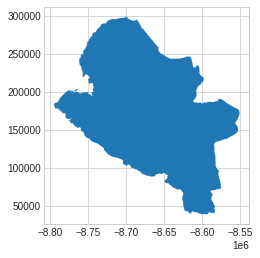

In [8]:
shapefile.plot()

In [9]:
from shapely.geometry import MultiPolygon

def points_from_polygons(polygons):
    points = []
    for mpoly in polygons:
        if isinstance(mpoly, MultiPolygon):
            polys = list(mpoly)
            print("YES")
        else:
            polys = [mpoly]
        for polygon in polys:
            for point in polygon.exterior.coords:
                points.append(point)
                
            for interior in polygon.interiors:
                for point in interior.coords:
                    points.append(point)
                
    return points

In [10]:
points = points_from_polygons(shapefile['geometry'])
#points = path_from_polygons(shapefile['geometry'])

#x = [point[0] for point in points]
#y = [point[1] for point in points]

YES


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  import sys


In [11]:
shp=shapefile['geometry']

In [12]:
import pandas as pd

from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV
from sklearnkernels.KSVM import  KSVC,KSVR

from sklearn.model_selection import train_test_split,KFold, cross_val_score,ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
import numpy as np
from time import time
from multiprocessing.pool import Pool
from sklearn.metrics import mean_absolute_error,mean_squared_error,median_absolute_error
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from matplotlib.colors import LinearSegmentedColormap

In [15]:
dff=pd.read_csv(path0+'landsat_model.csv')        
dff

,latitude,longitude,band1,band2,band3,band4,band5,band6,band7,value
0,-8789850.0,184950.0,0.105113,0.082716,0.052756,0.315520,0.132641,296.178607,0.044586,203.4
1,-8784900.0,174600.0,0.104840,0.085732,0.053527,0.271463,0.090247,295.969710,0.027292,198.3
2,-8775000.0,164700.0,0.103468,0.079147,0.048932,0.248619,0.078593,296.842689,0.022098,203.1
3,-8775000.0,169650.0,0.108849,0.090665,0.055715,0.338889,0.128227,296.123927,0.039798,199.1
4,-8775000.0,174600.0,0.096526,0.071028,0.042247,0.194788,0.054468,294.407491,0.017712,196.3
...,...,...,...,...,...,...,...,...,...,...
429,-8559900.0,154800.0,0.078925,0.066239,0.047267,0.270656,0.109293,289.724062,0.044993,237.5
430,-8559900.0,169650.0,0.063235,0.047407,0.031352,0.156130,0.061570,286.148731,0.025417,236.1
431,-8559900.0,174600.0,0.078075,0.063393,0.042869,0.230624,0.089819,290.305318,0.035603,234.4
432,-8554950.0,154800.0,0.088854,0.074230,0.049634,0.296663,0.132079,293.226199,0.048379,221.4


In [16]:
list(zip(dff.min(),dff.max()))

[(-8789850.0, -8554950.0),
 (45000.0, 294750.0),
 (0.0632353550551252, 0.12140827668878999),
 (0.047406927923657007, 0.10228294283352),
 (0.031073458773133996, 0.0785891646003744),
 (0.15612999498268398, 0.40950245505059396),
 (0.0544675073321401, 0.262650167921568),
 (286.148731219607, 302.222216239513),
 (0.0177120664674527, 0.11792623003068001),
 (188.5, 247.3)]

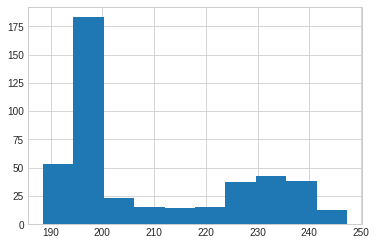

In [17]:
dff["value"].hist()

In [18]:
def targeter(n_clases,min_v,max_v, val):
  intervals=np.linspace(min_v,max_v,n_clases)
  
  n=len(intervals)
  for i in range(n-1):    
    if val>=intervals[i] and val<intervals[i+1]:
      return i;
    if val == max_v:
      return n_clases-1


In [19]:
min_v=dff.value.min()
max_v=dff.value.max()
min_v,max_v

(188.5, 247.3)

In [20]:
from sklearn.preprocessing import KBinsDiscretizer

n_clases=5
dff['class_eq']=dff.value.apply(lambda x: targeter(n_clases,min_v,max_v,x))

dff['class2_km']=KBinsDiscretizer(n_bins=n_clases, encode='ordinal',strategy = "kmeans").fit_transform(dff[['value']])

dff['class2_qt']=KBinsDiscretizer(n_bins=n_clases, encode='ordinal',strategy = "quantile").fit_transform(dff[['value']])

dff['class2_uf']=KBinsDiscretizer(n_bins=n_clases, encode='ordinal',strategy = "uniform").fit_transform(dff[['value']])

In [21]:

dff

,latitude,longitude,band1,band2,band3,band4,band5,band6,band7,value,class_eq,class2_km,class2_qt,class2_uf
0,-8789850.0,184950.0,0.105113,0.082716,0.052756,0.315520,0.132641,296.178607,0.044586,203.4,1,1.0,2.0,1.0
1,-8784900.0,174600.0,0.104840,0.085732,0.053527,0.271463,0.090247,295.969710,0.027292,198.3,0,0.0,2.0,0.0
2,-8775000.0,164700.0,0.103468,0.079147,0.048932,0.248619,0.078593,296.842689,0.022098,203.1,0,1.0,2.0,1.0
3,-8775000.0,169650.0,0.108849,0.090665,0.055715,0.338889,0.128227,296.123927,0.039798,199.1,0,0.0,2.0,0.0
4,-8775000.0,174600.0,0.096526,0.071028,0.042247,0.194788,0.054468,294.407491,0.017712,196.3,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,-8559900.0,154800.0,0.078925,0.066239,0.047267,0.270656,0.109293,289.724062,0.044993,237.5,3,4.0,4.0,4.0
430,-8559900.0,169650.0,0.063235,0.047407,0.031352,0.156130,0.061570,286.148731,0.025417,236.1,3,4.0,4.0,4.0
431,-8559900.0,174600.0,0.078075,0.063393,0.042869,0.230624,0.089819,290.305318,0.035603,234.4,3,4.0,4.0,3.0
432,-8554950.0,154800.0,0.088854,0.074230,0.049634,0.296663,0.132079,293.226199,0.048379,221.4,2,2.0,3.0,2.0


Text(0.5, 1.0, 'Uniform')

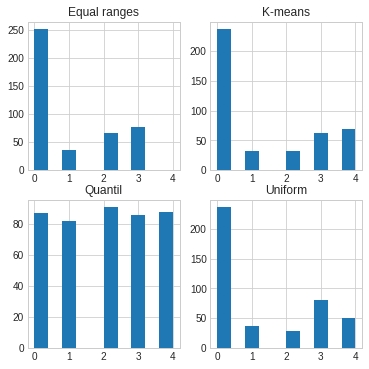

In [22]:
plt.figure(figsize=(6,6))
plt.subplot(2,2,1)
plt.title("Equal ranges")
dff["class_eq"].hist()
plt.subplot(2,2,2)
dff["class2_km"].hist()
plt.title("K-means")
plt.subplot(2,2,3)
dff["class2_qt"].hist()
plt.title("Quantil")
plt.subplot(2,2,4)
dff["class2_uf"].hist()
plt.title("Uniform")

In [ ]:
np.unique(dff['class_eq']),np.unique(dff['class2_km']),np.unique(dff['class2_qt']),np.unique(dff['class2_uf'])

(array([0, 1, 2, 3, 4]),
 array([0., 1., 2., 3., 4.]),
 array([0., 1., 2., 3., 4.]),
 array([0., 1., 2., 3., 4.]))

In [ ]:
dff.drop(['value'], axis=1, inplace=True)
dff

,latitude,longitude,band1,band2,band3,band4,band5,band6,band7,class_eq,class2_km,class2_qt,class2_uf
0,-8789850.0,184950.0,0.105113,0.082716,0.052756,0.315520,0.132641,296.178607,0.044586,1,1.0,2.0,1.0
1,-8784900.0,174600.0,0.104840,0.085732,0.053527,0.271463,0.090247,295.969710,0.027292,0,0.0,2.0,0.0
2,-8775000.0,164700.0,0.103468,0.079147,0.048932,0.248619,0.078593,296.842689,0.022098,0,1.0,2.0,1.0
3,-8775000.0,169650.0,0.108849,0.090665,0.055715,0.338889,0.128227,296.123927,0.039798,0,0.0,2.0,0.0
4,-8775000.0,174600.0,0.096526,0.071028,0.042247,0.194788,0.054468,294.407491,0.017712,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,-8559900.0,154800.0,0.078925,0.066239,0.047267,0.270656,0.109293,289.724062,0.044993,3,4.0,4.0,4.0
430,-8559900.0,169650.0,0.063235,0.047407,0.031352,0.156130,0.061570,286.148731,0.025417,3,4.0,4.0,4.0
431,-8559900.0,174600.0,0.078075,0.063393,0.042869,0.230624,0.089819,290.305318,0.035603,3,4.0,4.0,3.0
432,-8554950.0,154800.0,0.088854,0.074230,0.049634,0.296663,0.132079,293.226199,0.048379,2,2.0,3.0,2.0


# Experimentación

Se extraen las carácteristicas y etiquetas del conjunto de datos

In [ ]:
dff.iloc[:,0:9]

,latitude,longitude,band1,band2,band3,band4,band5,band6,band7
0,-8789850.0,184950.0,0.105113,0.082716,0.052756,0.315520,0.132641,296.178607,0.044586
1,-8784900.0,174600.0,0.104840,0.085732,0.053527,0.271463,0.090247,295.969710,0.027292
2,-8775000.0,164700.0,0.103468,0.079147,0.048932,0.248619,0.078593,296.842689,0.022098
3,-8775000.0,169650.0,0.108849,0.090665,0.055715,0.338889,0.128227,296.123927,0.039798
4,-8775000.0,174600.0,0.096526,0.071028,0.042247,0.194788,0.054468,294.407491,0.017712
...,...,...,...,...,...,...,...,...,...
429,-8559900.0,154800.0,0.078925,0.066239,0.047267,0.270656,0.109293,289.724062,0.044993
430,-8559900.0,169650.0,0.063235,0.047407,0.031352,0.156130,0.061570,286.148731,0.025417
431,-8559900.0,174600.0,0.078075,0.063393,0.042869,0.230624,0.089819,290.305318,0.035603
432,-8554950.0,154800.0,0.088854,0.074230,0.049634,0.296663,0.132079,293.226199,0.048379


In [ ]:
dff.iloc[:,-4],dff.iloc[:,-3],dff.iloc[:,-2],dff.iloc[:,-1]

(0      1
 1      0
 2      0
 3      0
 4      0
       ..
 429    3
 430    3
 431    3
 432    2
 433    3
 Name: class_eq, Length: 434, dtype: int64, 0      1.0
 1      0.0
 2      1.0
 3      0.0
 4      0.0
       ... 
 429    4.0
 430    4.0
 431    4.0
 432    2.0
 433    4.0
 Name: class2_km, Length: 434, dtype: float64, 0      2.0
 1      2.0
 2      2.0
 3      2.0
 4      1.0
       ... 
 429    4.0
 430    4.0
 431    4.0
 432    3.0
 433    4.0
 Name: class2_qt, Length: 434, dtype: float64, 0      1.0
 1      0.0
 2      1.0
 3      0.0
 4      0.0
       ... 
 429    4.0
 430    4.0
 431    3.0
 432    2.0
 433    4.0
 Name: class2_uf, Length: 434, dtype: float64)

In [ ]:

X=dff.iloc[:,0:9].to_numpy()
yeq=dff.iloc[:,-4].to_numpy()
ykm=dff.iloc[:,-3].to_numpy()
yqt=dff.iloc[:,-2].to_numpy()
yuf=dff.iloc[:,-1].to_numpy()
X.shape,y.shape

((434, 9), (434,))

### Partición de datos

### PipeLines

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.svm import  SVC
p_sts_ksvc = Pipeline([('sscaler', StandardScaler()), ('svc', KSVC())])
p_mms_ksvc = Pipeline([('mscaler', MinMaxScaler()), ('svc', KSVC())])
p_nms_ksvc = Pipeline([('nscaler', Normalizer()), ('svc', KSVC())])

pipes=[{"name":"SScaler","pipe":p_sts_ksvc},{"name":"MMScaler","pipe":p_mms_ksvc},{"name":"NMScaler","pipe":p_nms_ksvc}]

### Parametros

In [ ]:
rq_params={"svc__kernel": ['rquadratic'], "svc__C": np.logspace(0,5,10),"svc__coef0" : np.logspace(-4,4,20),"svc__gamma" : ["auto"]}
rbf_params={"svc__kernel": ['rbf'],"svc__C": np.logspace(0,5,10), "svc__gamma" : np.logspace(-4,4,20)}
tru_params={"svc__kernel": ['tru'],"svc__C": np.logspace(0,5,10), "svc__gamma" : np.logspace(-4,4,20)}
can_params={"svc__kernel": ['can'],"svc__C": np.logspace(0,5,10),"svc__gamma" : np.logspace(-4,4,20)}
rb_params={"svc__kernel": ['radial_basic'],"svc__C": np.logspace(0,5,10),"svc__gamma" : np.logspace(-4,4,20)}
tri_params={"svc__kernel": ['triangle'],"svc__C": np.logspace(0,5,10),"svc__gamma" : np.logspace(-4,4,20)}
hp_params={"svc__kernel": ['hyperbolic'],"svc__C": np.logspace(0,5,10), "svc__gamma" : np.logspace(-4,4,20)}

params=[rq_params,rbf_params,tru_params,can_params,rb_params,tri_params,hp_params]
#params=[rbf_params]

## Sintonizando

In [ ]:
def random_searchFit(X,y,filename):
  best_params=[]
  for pipe in pipes:
    print(pipe["name"])
    for param in params:    
      print(param)    
      clf=RandomizedSearchCV(pipe["pipe"],param,cv=5, random_state=2021, n_jobs=-1)
      clf.fit(X,y)
      best_params.append({"pipe":pipe["name"],"best_params":clf.best_params_,"score":clf.best_score_, "cv_results":clf.cv_results_})
      print(clf.best_score_)

  lst_best_params=[]

  for bp in  best_params:
    mean_test_score=bp['cv_results']['mean_test_score']  
    mean_fit_time=bp['cv_results']['mean_fit_time']
    mean_score_time=bp['cv_results']['mean_score_time']
    std_test_score=bp['cv_results']['std_test_score']
    std_fit_time=bp['cv_results']['std_fit_time']
    std_score_time=bp['cv_results']['std_score_time']
    
    i=np.argmax(mean_test_score)
    lst_best_params.append({
        'Scaler':bp['pipe'],
        'kernel':bp['best_params']['svc__kernel'],
        'mean_test_score':mean_test_score[i],
        'std_test_score':std_test_score[i],
        'mean_fit_time':mean_fit_time[i],
        'std_fit_time':std_fit_time[i],
        'mean_score_time':mean_score_time[i],      
        'std_score_time':std_score_time[i],
        'best_param':bp['best_params']
        })
  df_bp=pd.DataFrame(lst_best_params)
  df_bp.to_csv(path0+filename)

In [ ]:
ys=[yeq,ykm,yqt,yuf]
files=["equal.csv","kmean.csv","quatil.csv","uniform.csv"]
for i,y in enumerate(ys):
  print(files[i])
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2021)
  random_searchFit(X,y,files[i])

equal.csv
SScaler
{'svc__kernel': ['rquadratic'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__coef0': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]), 'svc__gamma': ['auto']}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.755252606255012
{'svc__kernel': ['rbf'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7758887997861534
{'svc__kernel': ['tru'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7255279337075647
{'svc__kernel': ['can'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7068163592622293
{'svc__kernel': ['radial_basic'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7598235765838012
{'svc__kernel': ['triangle'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7346164127238706
{'svc__kernel': ['hyperbolic'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7598235765838012
MMScaler
{'svc__kernel': ['rquadratic'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__coef0': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]), 'svc__gamma': ['auto']}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7597701149425287
{'svc__kernel': ['rbf'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7368350708366748
{'svc__kernel': ['tru'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7368350708366747
{'svc__kernel': ['can'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7231221598503075
{'svc__kernel': ['radial_basic'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7644212777332264
{'svc__kernel': ['triangle'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7413793103448276
{'svc__kernel': ['hyperbolic'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7414327719860999
NMScaler
{'svc__kernel': ['rquadratic'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__coef0': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]), 'svc__gamma': ['auto']}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.6287089013632718
{'svc__kernel': ['rbf'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.6333333333333333
{'svc__kernel': ['tru'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.6884522854851645
{'svc__kernel': ['can'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7532477947072975
{'svc__kernel': ['radial_basic'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.6057471264367816
{'svc__kernel': ['triangle'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7
{'svc__kernel': ['hyperbolic'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.5783480352846833
kmean.csv
SScaler
{'svc__kernel': ['rquadratic'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__coef0': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]), 'svc__gamma': ['auto']}
0.7207965784549586
{'svc__kernel': ['rbf'], 'svc__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]), 'svc__gamma': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03